In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet18
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 23
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

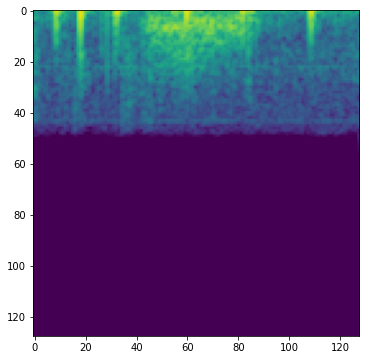

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.7634914128954586
TEST
loss: 0.6412053961602469
accuracy: 0.7523809523809524
******************
epoch: 1
Train
0.5053768889169261
TEST
loss: 0.593953984502762
accuracy: 0.8126984126984127
******************
epoch: 2
Train
0.428995743926505
TEST
loss: 0.4729451044211312
accuracy: 0.7904761904761904
******************
epoch: 3
Train
0.40389472179890057
TEST
loss: 0.6031107115367103
accuracy: 0.7873015873015873
******************
epoch: 4
Train
0.2810993601728565
TEST
loss: 0.8017780039045546
accuracy: 0.7619047619047619
******************
epoch: 5
Train
0.30792124468812493
TEST
loss: 0.6869943357649304
accuracy: 0.7555555555555555
******************
epoch: 6
Train
0.21429484509186106
TEST
loss: 0.6342346236819313
accuracy: 0.7587301587301587
******************
epoch: 7
Train
0.2045870524867363
TEST
loss: 0.9557823088434008
accuracy: 0.8063492063492064
******************
epoch: 8
Train
0.20360418193107374
TEST
loss: 1.1825044071863569
accuracy: 0.6507936507936508
*********

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


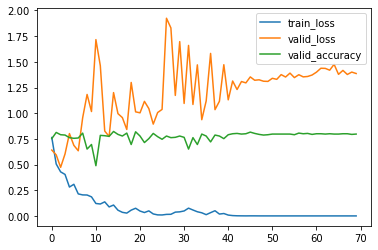

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8782786832289434
TEST
loss: 0.7046693290036822
accuracy: 0.7746031746031746
******************
epoch: 1
Train
0.6026025383694007
TEST
loss: 0.5847607771555583
accuracy: 0.7936507936507936
******************
epoch: 2
Train
0.5179181935959529
TEST
loss: 0.596195464947867
accuracy: 0.7936507936507936
******************
epoch: 3
Train
0.46075188995259825
TEST
loss: 1.416272589138576
accuracy: 0.3873015873015873
******************
epoch: 4
Train
0.4638127422550541
TEST
loss: 1.6042385195928908
accuracy: 0.43492063492063493
******************
epoch: 5
Train
0.419635624521966
TEST
loss: 0.522783077425427
accuracy: 0.8126984126984127
******************
epoch: 6
Train
0.3951321733764848
TEST
loss: 0.855492951945653
accuracy: 0.7587301587301587
******************
epoch: 7
Train
0.3777977736626853
TEST
loss: 0.7018555022421338
accuracy: 0.7333333333333333
******************
epoch: 8
Train
0.3400130144559362
TEST
loss: 0.7655711395399911
accuracy: 0.7

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


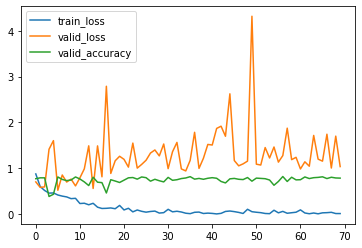

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.87682053418364
TEST
loss: 1.630091555156405
accuracy: 0.6952380952380952
******************
epoch: 1
Train
0.6507199902303452
TEST
loss: 0.701930440418304
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.5370463829744989
TEST
loss: 0.7936225430359916
accuracy: 0.7746031746031746
******************
epoch: 3
Train
0.46719674248843085
TEST
loss: 0.7538294412786999
accuracy: 0.6984126984126984
******************
epoch: 4
Train
0.45197243073613425
TEST
loss: 0.45207760868564484
accuracy: 0.8380952380952381
******************
epoch: 5
Train
0.3992886671809756
TEST
loss: 1.0578005783141606
accuracy: 0.7111111111111111
******************
epoch: 6
Train
0.3323476180801134
TEST
loss: 0.6791651011459411
accuracy: 0.7904761904761904
******************
epoch: 7
Train
0.3362668711482011
TEST
loss: 0.715617337113335
accuracy: 0.6634920634920635
******************
epoch: 8
Train
0.2876311559540777
TEST
loss: 0.7089200027405269
accuracy: 0.

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


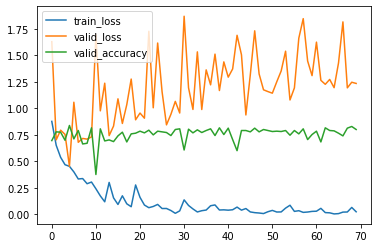

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.7370438250025839
TEST
loss: 1.149312150478363
accuracy: 0.5904761904761905
******************
epoch: 1
Train
0.5311715261769541
TEST
loss: 0.7452426049444411
accuracy: 0.8031746031746032
******************
epoch: 2
Train
0.43145846486138956
TEST
loss: 1.0211690270711504
accuracy: 0.5746031746031746
******************
epoch: 3
Train
0.4318180227677343
TEST
loss: 0.5460470560997251
accuracy: 0.780952380952381
******************
epoch: 4
Train
0.32834978106951695
TEST
loss: 0.6005529000645592
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.32923823448284173
TEST
loss: 0.9369816698725262
accuracy: 0.6253968253968254
******************
epoch: 6
Train
0.20878663398710104
TEST
loss: 0.9403039871700226
accuracy: 0.7301587301587301
******************
epoch: 7
Train
0.2953171147014339
TEST
loss: 1.2551105552249484
accuracy: 0.6285714285714286
******************
epoch: 8
Train
0.2258790114020146
TEST
loss: 0.9460113442133343
accuracy

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8401015228426396


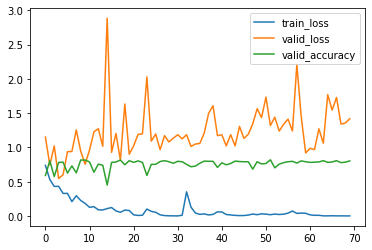

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.7659033927607858
TEST
loss: 0.9465329009389121
accuracy: 0.7396825396825397
******************
epoch: 1
Train
0.5244900518651042
TEST
loss: 0.5178719850759658
accuracy: 0.7841269841269841
******************
epoch: 2
Train
0.48186743742326976
TEST
loss: 0.8074418423667786
accuracy: 0.7904761904761904
******************
epoch: 3
Train
0.39300263330423235
TEST
loss: 0.835148747194381
accuracy: 0.8
******************
epoch: 4
Train
0.3477039486998315
TEST
loss: 0.9941330219072009
accuracy: 0.726984126984127
******************
epoch: 5
Train
0.3406806535533584
TEST
loss: 0.9245717005124168
accuracy: 0.746031746031746
******************
epoch: 6
Train
0.2737179683777337
TEST
loss: 0.5784399976806035
accuracy: 0.7555555555555555
******************
epoch: 7
Train
0.22225807619009633
TEST
loss: 0.7594054521076263
accuracy: 0.7714285714285715
******************
epoch: 8
Train
0.19358814861018853
TEST
loss: 2.608601724533808
accuracy: 0.4031746031746

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


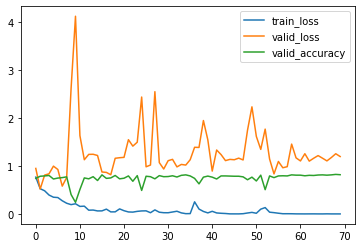

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9561316672893059
TEST
loss: 1.4520115632859487
accuracy: 0.7365079365079366
******************
epoch: 1
Train
0.5852153440663699
TEST
loss: 0.5969205655748882
accuracy: 0.746031746031746
******************
epoch: 2
Train
0.5743618190904001
TEST
loss: 0.5279718653550224
accuracy: 0.8222222222222222
******************
epoch: 3
Train
0.5222576704405905
TEST
loss: 0.5590051861036391
accuracy: 0.7936507936507936
******************
epoch: 4
Train
0.49596754059704456
TEST
loss: 0.8341861486434936
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.48842245335613005
TEST
loss: 0.6117716350252667
accuracy: 0.7523809523809524
******************
epoch: 6
Train
0.4739634849137025
TEST
loss: 0.5067053588609847
accuracy: 0.8063492063492064
******************
epoch: 7
Train
0.43902560741869207
TEST
loss: 0.610688469807307
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.4221139160577412
TEST
loss: 0.6455475534711566
accuracy:

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8451776649746193


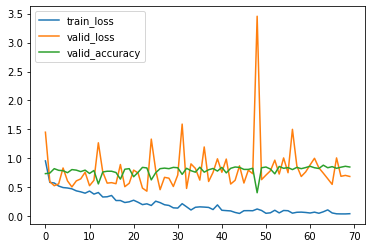

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.0856116822638902
TEST
loss: 0.8986297225195264
accuracy: 0.6793650793650794
******************
epoch: 1
Train
0.6977863014927925
TEST
loss: 0.8927280021092249
accuracy: 0.40634920634920635
******************
epoch: 2
Train
0.6829464862136447
TEST
loss: 0.6718784163868616
accuracy: 0.7428571428571429
******************
epoch: 3
Train
0.6210926137243215
TEST
loss: 0.5417782685113331
accuracy: 0.8253968253968254
******************
epoch: 4
Train
0.617662580596539
TEST
loss: 0.6244169457564278
accuracy: 0.7682539682539683
******************
epoch: 5
Train
0.6046522927719795
TEST
loss: 0.6527015438155522
accuracy: 0.765079365079365
******************
epoch: 6
Train
0.5996295270510758
TEST
loss: 0.5285601508049738
accuracy: 0.8031746031746032
******************
epoch: 7
Train
0.5586700202738888
TEST
loss: 0.8689051153167846
accuracy: 0.6349206349206349
******************
epoch: 8
Train
0.5996678242899294
TEST
loss: 0.7684533614960928
accuracy: 0

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


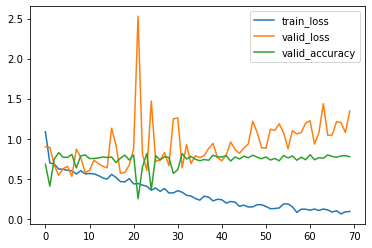

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9177885179816967
TEST
loss: 1.3685568730036417
accuracy: 0.546031746031746
******************
epoch: 1
Train
0.6392806084786643
TEST
loss: 1.0439776223803323
accuracy: 0.6952380952380952
******************
epoch: 2
Train
0.6479653636551358
TEST
loss: 0.5801196567595951
accuracy: 0.8031746031746032
******************
epoch: 3
Train
0.5971623676177337
TEST
loss: 0.7997568804120261
accuracy: 0.7111111111111111
******************
epoch: 4
Train
0.5576012288889685
TEST
loss: 0.637513926672557
accuracy: 0.7587301587301587
******************
epoch: 5
Train
0.5321775798384778
TEST
loss: 0.6711246137581174
accuracy: 0.7492063492063492
******************
epoch: 6
Train
0.4821499771689308
TEST
loss: 0.6064949936336941
accuracy: 0.780952380952381
******************
epoch: 7
Train
0.4351756799022199
TEST
loss: 0.7066506724508982
accuracy: 0.6666666666666666
******************
epoch: 8
Train
0.47079754320755185
TEST
loss: 0.6468077393751296
accuracy: 0.

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


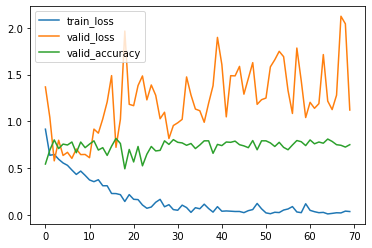

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.848164005481695
TEST
loss: 0.6140156212307158
accuracy: 0.7936507936507936
******************
epoch: 1
Train
0.5484176244974326
TEST
loss: 0.680989222299485
accuracy: 0.7587301587301587
******************
epoch: 2
Train
0.48078749649007707
TEST
loss: 0.8556579485772148
accuracy: 0.746031746031746
******************
epoch: 3
Train
0.42536871986222513
TEST
loss: 0.6297507568011208
accuracy: 0.7904761904761904
******************
epoch: 4
Train
0.38451075298242665
TEST
loss: 2.0406902381352015
accuracy: 0.6476190476190476
******************
epoch: 5
Train
0.36115125192120684
TEST
loss: 0.8263907703142318
accuracy: 0.7301587301587301
******************
epoch: 6
Train
0.2785593381919399
TEST
loss: 0.6433789565449669
accuracy: 0.819047619047619
******************
epoch: 7
Train
0.23115977798784604
TEST
loss: 0.8196120725737678
accuracy: 0.8158730158730159
******************
epoch: 8
Train
0.23610386982666678
TEST
loss: 1.025924274845729
accuracy:

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8223350253807107


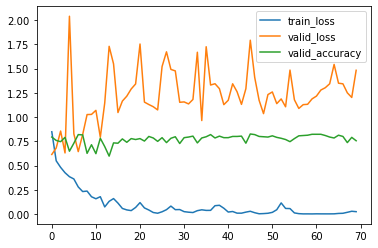

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8435390005398592
TEST
loss: 0.6054417621521723
accuracy: 0.8063492063492064
******************
epoch: 1
Train
0.5626761300209687
TEST
loss: 0.6342858999494523
accuracy: 0.7968253968253968
******************
epoch: 2
Train
0.48141446482387207
TEST
loss: 0.7592800628571283
accuracy: 0.7682539682539683
******************
epoch: 3
Train
0.39243750231572805
TEST
loss: 0.567417231438652
accuracy: 0.8
******************
epoch: 4
Train
0.38615069027643906
TEST
loss: 1.113172261298649
accuracy: 0.7238095238095238
******************
epoch: 5
Train
0.344503491051714
TEST
loss: 0.5959878417234572
accuracy: 0.7968253968253968
******************
epoch: 6
Train
0.3056726041438563
TEST
loss: 0.5168401985887497
accuracy: 0.8126984126984127
******************
epoch: 7
Train
0.25250472107086985
TEST
loss: 0.8814954110554286
accuracy: 0.7142857142857143
******************
epoch: 8
Train
0.1781121883201069
TEST
loss: 1.503700381612021
accuracy: 0.6317460317460

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8426395939086294


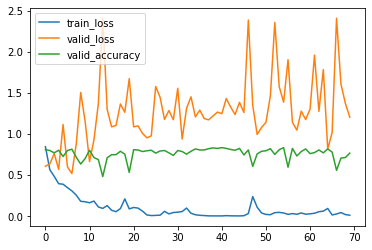

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.7887149542522771
TEST
loss: 0.6696925392226567
accuracy: 0.7682539682539683
******************
epoch: 1
Train
0.5902805217586878
TEST
loss: 0.5879146352646842
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.5570271488595709
TEST
loss: 0.5615488752486214
accuracy: 0.8095238095238095
******************
epoch: 3
Train
0.5029026638358429
TEST
loss: 0.5541811256181626
accuracy: 0.7968253968253968
******************
epoch: 4
Train
0.5150671638222892
TEST
loss: 1.123149089207725
accuracy: 0.6825396825396826
******************
epoch: 5
Train
0.4847742502797303
TEST
loss: 1.2750148042799934
accuracy: 0.4984126984126984
******************
epoch: 6
Train
0.4588745767110108
TEST
loss: 0.5114956488685002
accuracy: 0.8158730158730159
******************
epoch: 7
Train
0.4252204246422523
TEST
loss: 0.9568693094783359
accuracy: 0.6761904761904762
******************
epoch: 8
Train
0.4256784825499234
TEST
loss: 1.5054371069348047
accuracy: 0

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8807106598984772


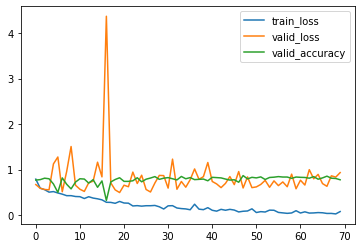

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.0766904992040327
TEST
loss: 0.7175701203800383
accuracy: 0.726984126984127
******************
epoch: 1
Train
0.7130883817070528
TEST
loss: 0.8261688699797979
accuracy: 0.6317460317460317
******************
epoch: 2
Train
0.6904947154099644
TEST
loss: 0.5910593945828695
accuracy: 0.780952380952381
******************
epoch: 3
Train
0.639570378423968
TEST
loss: 0.6591042641609434
accuracy: 0.7523809523809524
******************
epoch: 4
Train
0.618603711259848
TEST
loss: 0.6049816453267658
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.6030959889138853
TEST
loss: 0.7895629078622848
accuracy: 0.6285714285714286
******************
epoch: 6
Train
0.6031392001272479
TEST
loss: 0.594967738598112
accuracy: 0.7873015873015873
******************
epoch: 7
Train
0.5950874595342883
TEST
loss: 0.595209552938976
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.6033391564303301
TEST
loss: 0.5805731977735247
accuracy: 0.7936

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


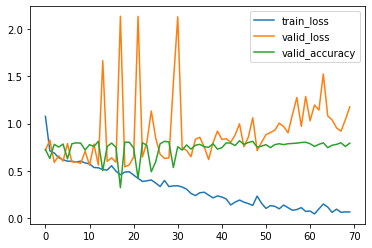

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8520394677889546
TEST
loss: 0.6325310881175692
accuracy: 0.7714285714285715
******************
epoch: 1
Train
0.593152679461539
TEST
loss: 0.7420519520366002
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.5510144542378977
TEST
loss: 0.828904125993214
accuracy: 0.7492063492063492
******************
epoch: 3
Train
0.5167421888178355
TEST
loss: 0.5787515705540067
accuracy: 0.7968253968253968
******************
epoch: 4
Train
0.49797603104491384
TEST
loss: 1.2305240192110576
accuracy: 0.6571428571428571
******************
epoch: 5
Train
0.5162771136823204
TEST
loss: 0.5602356536047799
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.46233785067218175
TEST
loss: 0.5205765336278885
accuracy: 0.7841269841269841
******************
epoch: 7
Train
0.43877527877581884
TEST
loss: 0.6140961970601763
accuracy: 0.7111111111111111
******************
epoch: 8
Train
0.4355313678977033
TEST
loss: 0.7411195491987561
accuracy:

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.883248730964467


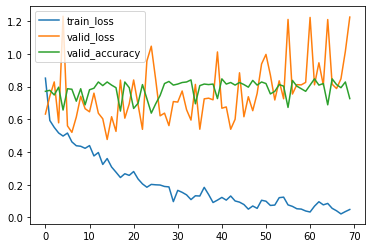

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.0364314329065532
TEST
loss: 1.4848081032435099
accuracy: 0.5111111111111111
******************
epoch: 1
Train
0.7035306471979174
TEST
loss: 0.6891316171676394
accuracy: 0.7619047619047619
******************
epoch: 2
Train
0.68507268743159
TEST
loss: 0.6872374434319753
accuracy: 0.7492063492063492
******************
epoch: 3
Train
0.6460601908995861
TEST
loss: 0.5718908542678469
accuracy: 0.7841269841269841
******************
epoch: 4
Train
0.6174752109338595
TEST
loss: 0.5597994583939749
accuracy: 0.7968253968253968
******************
epoch: 5
Train
0.600053402854868
TEST
loss: 0.5632179012374272
accuracy: 0.8031746031746032
******************
epoch: 6
Train
0.5752512863744716
TEST
loss: 0.5391806898609041
accuracy: 0.8158730158730159
******************
epoch: 7
Train
0.5543644868541654
TEST
loss: 0.5551660316331046
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.5542725344041305
TEST
loss: 0.6000889026929461
accuracy: 0.7

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8096446700507615


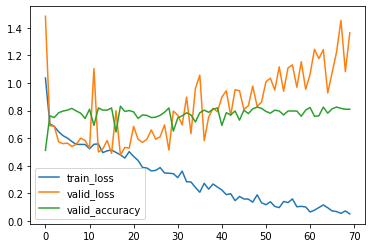

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.7784890787789895
TEST
loss: 0.5921695193601033
accuracy: 0.8
******************
epoch: 1
Train
0.558619903396102
TEST
loss: 0.5634784919875009
accuracy: 0.780952380952381
******************
epoch: 2
Train
0.5090874420261459
TEST
loss: 0.5789823726056114
accuracy: 0.7587301587301587
******************
epoch: 3
Train
0.464768027056769
TEST
loss: 0.7788301045932468
accuracy: 0.7174603174603175
******************
epoch: 4
Train
0.43609668606799024
TEST
loss: 0.5603236310065739
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.41020381281402396
TEST
loss: 0.5486944332955376
accuracy: 0.8126984126984127
******************
epoch: 6
Train
0.39132864031174336
TEST
loss: 0.6403525110275027
accuracy: 0.7047619047619048
******************
epoch: 7
Train
0.34808443821641166
TEST
loss: 0.6112740938625638
accuracy: 0.7841269841269841
******************
epoch: 8
Train
0.3416781336471521
TEST
loss: 1.0033448132257612
accuracy: 0.504761904761

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


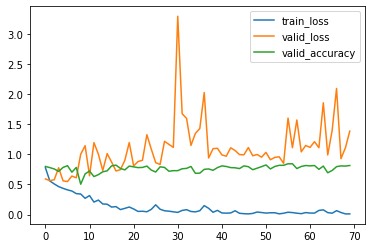

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.7827000244445892
TEST
loss: 0.7823022547222319
accuracy: 0.746031746031746
******************
epoch: 1
Train
0.5484411094139454
TEST
loss: 0.5553218719505129
accuracy: 0.7936507936507936
******************
epoch: 2
Train
0.5064012009156328
TEST
loss: 0.531666868641263
accuracy: 0.8095238095238095
******************
epoch: 3
Train
0.45564695967862867
TEST
loss: 0.7905417871853662
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.41195787990064825
TEST
loss: 1.0382446457469274
accuracy: 0.7333333333333333
******************
epoch: 5
Train
0.43001289262101233
TEST
loss: 0.6111395436619955
accuracy: 0.7365079365079366
******************
epoch: 6
Train
0.38874833679937765
TEST
loss: 0.6653945519810631
accuracy: 0.7904761904761904
******************
epoch: 7
Train
0.3552167790574247
TEST
loss: 0.8098014765315585
accuracy: 0.8063492063492064
******************
epoch: 8
Train
0.31936543772767895
TEST
loss: 2.016470262360951
accuracy

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


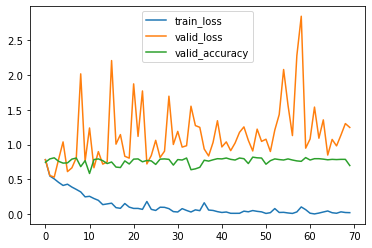

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.734898656902567
TEST
loss: 0.652774859610058
accuracy: 0.7873015873015873
******************
epoch: 1
Train
0.5357068131091199
TEST
loss: 0.7796839515368144
accuracy: 0.6793650793650794
******************
epoch: 2
Train
0.5009744089685612
TEST
loss: 0.6529584192094349
accuracy: 0.7904761904761904
******************
epoch: 3
Train
0.42227959023334377
TEST
loss: 0.9826963532538641
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.3980758611032942
TEST
loss: 0.9172792996679033
accuracy: 0.7365079365079366
******************
epoch: 5
Train
0.38996435172790755
TEST
loss: 0.6321506233442398
accuracy: 0.7396825396825397
******************
epoch: 6
Train
0.33569299204184766
TEST
loss: 1.5930407543030995
accuracy: 0.6857142857142857
******************
epoch: 7
Train
0.31769825257745593
TEST
loss: 0.7820183451213534
accuracy: 0.7555555555555555
******************
epoch: 8
Train
0.24096143269368445
TEST
loss: 0.9144407709439596
accurac

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8020304568527918


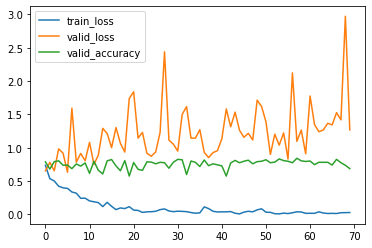

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8111187340580726
TEST
loss: 0.642520985527644
accuracy: 0.7873015873015873
******************
epoch: 1
Train
0.5329569345243967
TEST
loss: 0.794269913908035
accuracy: 0.6761904761904762
******************
epoch: 2
Train
0.4957181381459649
TEST
loss: 0.7679099626011319
accuracy: 0.7111111111111111
******************
epoch: 3
Train
0.4096251877884338
TEST
loss: 1.3891550900444152
accuracy: 0.6857142857142857
******************
epoch: 4
Train
0.38850261210637776
TEST
loss: 0.6460728831707485
accuracy: 0.7587301587301587
******************
epoch: 5
Train
0.36264946919476065
TEST
loss: 0.6126922208165365
accuracy: 0.7492063492063492
******************
epoch: 6
Train
0.30954277984105566
TEST
loss: 0.9529482569013323
accuracy: 0.6063492063492063
******************
epoch: 7
Train
0.2838899426700768
TEST
loss: 0.982750902289436
accuracy: 0.7714285714285715
******************
epoch: 8
Train
0.2276947528147527
TEST
loss: 0.704972862724274
accuracy: 0

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8147208121827412


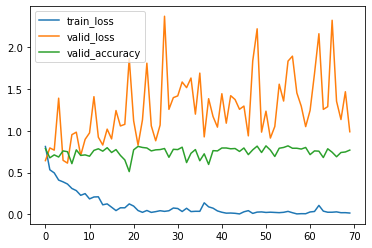

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.7944274139579466
TEST
loss: 0.6196774185649933
accuracy: 0.7841269841269841
******************
epoch: 1
Train
0.5617290104638024
TEST
loss: 0.7178781908655923
accuracy: 0.6825396825396826
******************
epoch: 2
Train
0.5392161273975236
TEST
loss: 0.5626958289789775
accuracy: 0.8031746031746032
******************
epoch: 3
Train
0.4354923635579178
TEST
loss: 1.0183041184667556
accuracy: 0.6888888888888889
******************
epoch: 4
Train
0.4362075482454444
TEST
loss: 0.5604307275915903
accuracy: 0.7746031746031746
******************
epoch: 5
Train
0.42009133862729486
TEST
loss: 0.5823802918668777
accuracy: 0.8285714285714286
******************
epoch: 6
Train
0.38977816622819667
TEST
loss: 0.8990991917867509
accuracy: 0.7238095238095238
******************
epoch: 7
Train
0.3553807592231002
TEST
loss: 0.5850671656548031
accuracy: 0.765079365079365
******************
epoch: 8
Train
0.3042991844267008
TEST
loss: 0.7990270862503658
accuracy:

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8426395939086294


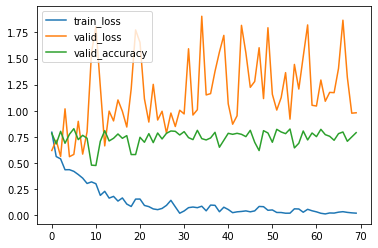

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9796177797889406
TEST
loss: 0.99672184766285
accuracy: 0.5746031746031746
******************
epoch: 1
Train
0.6501251562092397
TEST
loss: 0.834866015873258
accuracy: 0.638095238095238
******************
epoch: 2
Train
0.5962180971057761
TEST
loss: 0.6052430262641301
accuracy: 0.8031746031746032
******************
epoch: 3
Train
0.5395678129103375
TEST
loss: 0.6668983162395538
accuracy: 0.7904761904761904
******************
epoch: 4
Train
0.5271637402563648
TEST
loss: 0.5280343665017022
accuracy: 0.8253968253968254
******************
epoch: 5
Train
0.4843855632544511
TEST
loss: 0.5947024765468779
accuracy: 0.8
******************
epoch: 6
Train
0.4997481533087275
TEST
loss: 0.4945273927279881
accuracy: 0.8285714285714286
******************
epoch: 7
Train
0.4178174956863697
TEST
loss: 0.5007687282940698
accuracy: 0.8126984126984127
******************
epoch: 8
Train
0.38869038799435873
TEST
loss: 0.6822722565560114
accuracy: 0.819047619047619


In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8375634517766497


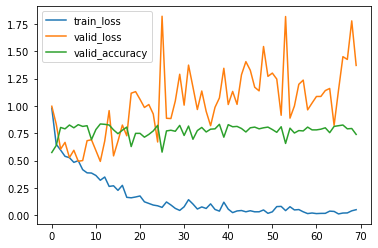

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()